In [ ]:
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
#from keras.utils import plot_model
#from IPython.display import SVG
#rom keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ROWS = 0
COLS = 0
CHANNELS = 0
CLASSES = 0

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
print ("number of training examples =", x_train.shape[0])
print ("number of test examples =", y_train.shape[0])
print ("X_train shape:", x_train.shape)
print ("Y_train shape:", y_train.shape)
print ("X_test shape:", x_test.shape)
print ("Y_test shape:", y_test.shape)

number of training examples = 60000
number of test examples = 60000
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)


In [ ]:
ROWS = x_train.shape[1]
COLS = x_train.shape[2]
CHANNELS = 1
CLASSES = 10

In [ ]:
train_img = x_train.reshape((-1,28,28,1))
test_img = x_test.reshape((-1,28,28,1))

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
     # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F2, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet34(input_shape, classes):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64], stage=2, block='b')
    X = identity_block(X, 3, [64, 64], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block='a', s = 1)
    X = identity_block(X, 3, [128, 128], stage=3, block='b')
    X = identity_block(X, 3, [128, 128], stage=3, block='c')
    X = identity_block(X, 3, [128, 128], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block='a', s = 1)
    X = identity_block(X, 3, [256, 256], stage=4, block='b')
    X = identity_block(X, 3, [256, 256], stage=4, block='c')
    X = identity_block(X, 3, [256, 256], stage=4, block='d')
    X = identity_block(X, 3, [256, 256], stage=4, block='e')
    X = identity_block(X, 3, [256, 256], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block='a', s = 1)
    X = identity_block(X, 3, [512, 512], stage=5, block='b')
    X = identity_block(X, 3, [512, 512], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet34')

    return model

In [ ]:
model = ResNet34(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 34, 34, 1)   0           ['input_19[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 14, 14, 64)   3200        ['zero_padding2d_18[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 14, 14, 64)   256         ['conv1[0][0]']           

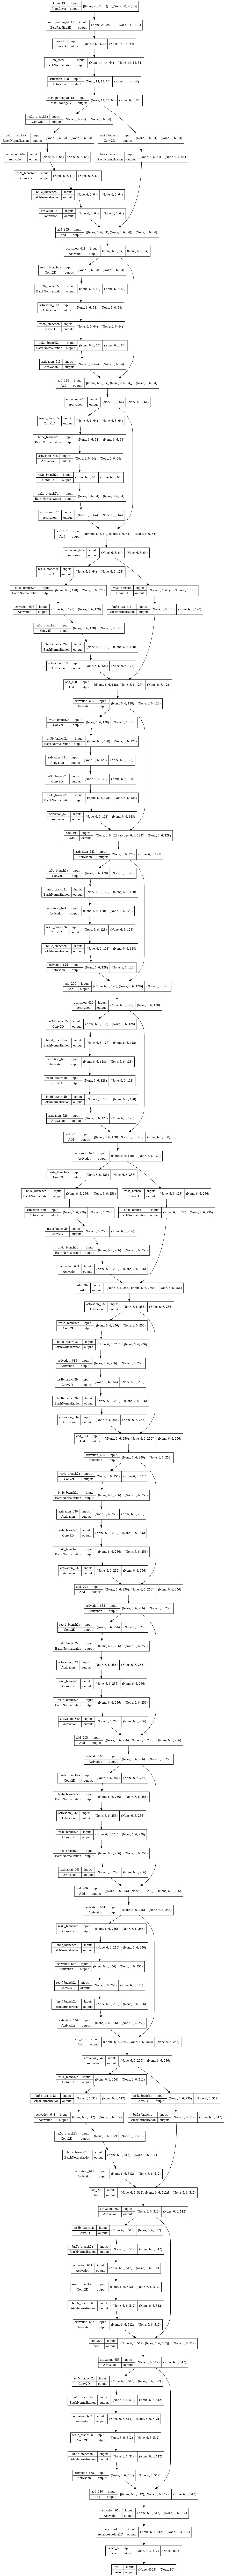

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_img,y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4019s 2s/step - loss: 0.5991 - accuracy: 0.8096
Epoch 2/5
1875/1875 [==============================] - 3998s 2s/step - loss: 0.3806 - accuracy: 0.8644
Epoch 3/5
1875/1875 [==============================] - 4010s 2s/step - loss: 0.3131 - accuracy: 0.8846
Epoch 4/5
1875/1875 [==============================] - 4030s 2s/step - loss: 0.2928 - accuracy: 0.8914
Epoch 5/5
1875/1875 [==============================] - 4013s 2s/step - loss: 0.2551 - accuracy: 0.9051


In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 140s - loss: 0.2949 - accuracy: 0.8891 - 140s/epoch - 449ms/step


[0.29491332173347473, 0.8891000151634216]

In [105]:
model.save('ResNet-Layer34.h5')

INFO:tensorflow:Assets written to: ResNet-Layer34/assets
